## WE11 - Autoencoder
### Subash Chandra Biswal (U77884251)
I have creates 5 28x28 .png images of first character(S) of my name(Subash).

In [1]:
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load our pretrained model

In [2]:
from tensorflow import keras

pretrained_model = keras.models.load_model('initially_trained_autoencoder.h5')

### Load MNIST data and normalize

In [3]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


### Reconstruct using pretrained model and plot sample images

313/313 [==============================] - 1s 3ms/step


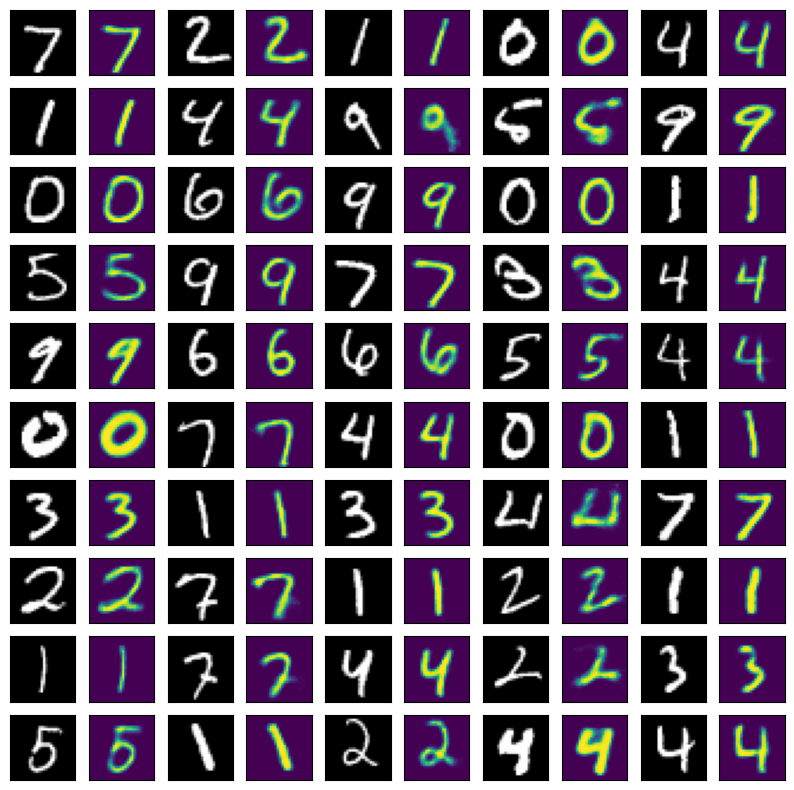

In [4]:
reconstructed_images = pretrained_model.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Load the character images

In [5]:
n=5
char_images = []
####################################
# load a sample image
for i in range(1,n+1):
    image = tf.keras.utils.load_img(str(i)+'.png', target_size=(28, 28), color_mode = "grayscale")
    char_images.append(image)


### Plot the character images

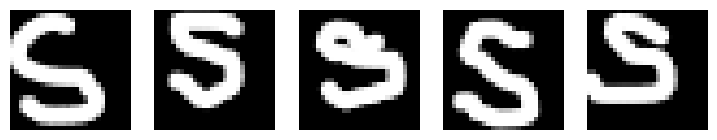

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(char_images[i], cmap="gray")
  ax.axis('off')

plt.show()

### Reshape the character Images

In [7]:
new_image_set = np.empty((0,784))
for i in range(n):
    input_arr = tf.keras.utils.img_to_array(char_images[i])
    input_arr = input_arr/ 255 # normalize between 0 and 1
    input_arr = input_arr.reshape(784)
    input_arr = np.array([input_arr]) 
    new_image_set = np.vstack((new_image_set,input_arr))
print(new_image_set.shape)
new_image_set = new_image_set.astype('float32') / 255

(5, 784)


### Mix the MNIST data and oversampling of character data

In [29]:
np.random.shuffle(train_images)
for i in range(n):
    sample_images = [new_image_set[i] for _ in range(1000)]
    mix_images = np.vstack((train_images, sample_images))
np.random.shuffle(mix_images)
print(mix_images.shape)

mix_images_train = mix_images[:int(len(mix_images)*.8)]
mix_images_test = mix_images[int(len(mix_images)*.8):]

(61000, 784)


In [39]:
mix_images_train.shape

(48800, 784)

### Create a new Autoencoder model

In [36]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

input_dim = 28*28
latent_vec_len = 40 # this is the 'bottleneck' of the autoencoder

# Define the autoencoder architecture
# build the encoder
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_dim,)))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(100, activation='relu'))

# the bottleneck layer
autoencoder.add(Dense(latent_vec_len, activation='relu'))

# the decoder layer
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# Compile the autoencoder model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Get summary
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 500)               392500    
                                                                 
 dense_41 (Dense)            (None, 300)               150300    
                                                                 
 dense_42 (Dense)            (None, 100)               30100     
                                                                 
 dense_43 (Dense)            (None, 40)                4040      
                                                                 
 dense_44 (Dense)            (None, 100)               4100      
                                                                 
 dense_45 (Dense)            (None, 300)               30300     
                                                                 
 dense_46 (Dense)            (None, 500)              

### Fit the model on train data 

In [37]:
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training


# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = autoencoder.fit(
    x=mix_images_train, # For autoencoders, both the input and the target are the same
    y=mix_images_train, 
    epochs=10, 
    batch_size=128,
    shuffle=True, 
    validation_data=(mix_images_test, mix_images_test),
    callbacks=[early_stop]
)

Epoch 1/10
382/382 [==============================] - 9s 20ms/step - loss: 0.1933 - val_loss: 0.1363
Epoch 2/10
382/382 [==============================] - 8s 20ms/step - loss: 0.1234 - val_loss: 0.1162
Epoch 3/10
382/382 [==============================] - 16s 41ms/step - loss: 0.1093 - val_loss: 0.1069
Epoch 4/10
382/382 [==============================] - 16s 42ms/step - loss: 0.1022 - val_loss: 0.1008
Epoch 5/10
382/382 [==============================] - 16s 42ms/step - loss: 0.0974 - val_loss: 0.0977
Epoch 6/10
382/382 [==============================] - 16s 41ms/step - loss: 0.0943 - val_loss: 0.0942
Epoch 7/10
382/382 [==============================] - 16s 42ms/step - loss: 0.0915 - val_loss: 0.0922
Epoch 8/10
382/382 [==============================] - 16s 42ms/step - loss: 0.0893 - val_loss: 0.0906
Epoch 9/10
382/382 [==============================] - 16s 42ms/step - loss: 0.0876 - val_loss: 0.0886
Epoch 10/10
382/382 [==============================] - 16s 42ms/step - loss: 0.0863 

### Test the model on Digits

313/313 [==============================] - 3s 10ms/step


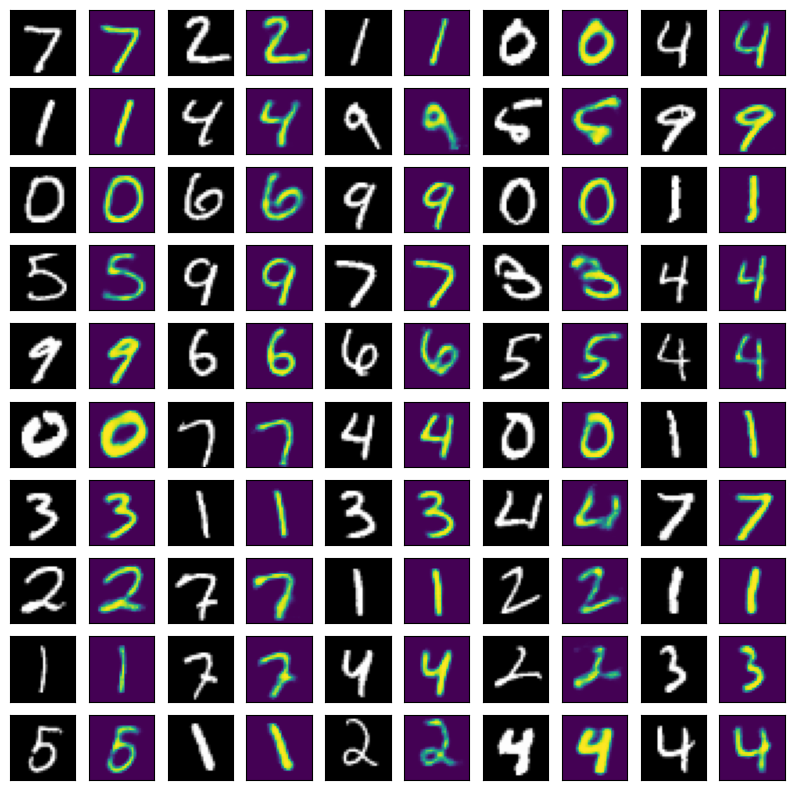

In [38]:
reconstructed_images = autoencoder.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Test the model on character

1/1 [==============================] - 0s 41ms/step
(1, 784)


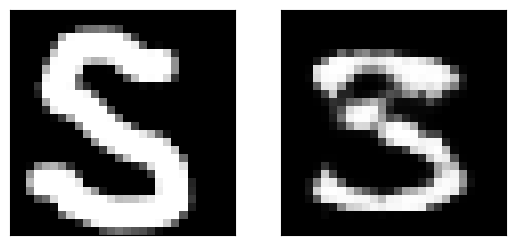

In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image


####################################
# load a sample image
image = tf.keras.utils.load_img('4.png', target_size=(28, 28), color_mode = "grayscale")


####################################
# predict an image from this sample
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/ 255 # normalize between 0 and 1
input_arr = input_arr.reshape(784)
input_arr = np.array([input_arr])  # Convert single image to a batch with one image in it

predictions = autoencoder.predict(input_arr)
print(predictions.shape)


#####################################
# display the two images side by side
# 
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()


### Save the model

In [46]:
autoencoder.save('mix_trained_autoencoder.h5')